In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
file_path = 'C:/Users/Tim/Desktop/lighthouse/w6 - midterm/'
# filename = file_path+'flights.csv'

# n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
# s = 50000 #desired sample size
# skip = sorted(random.sample(range(1,n+1),n-s))
# df = pd.read_csv(filename,skiprows=skip)

filename = file_path+'mini_sample.csv'
df = pd.read_csv(filename)

In [3]:
data = copy.deepcopy(df)

In [4]:
# cols with > 80% missing values

drop = [
    'no_name',
    'total_add_gtime',
    'first_dep_time',
    'longest_add_gtime',
    'cancellation_code',
]

# missing 80%+ values, but apparently useful?

delay_cols = [
    'late_aircraft_delay',
    'security_delay',
    'nas_delay',
    'weather_delay',
    'carrier_delay'
]

In [5]:
# split city and country

data[['origin_city', 'origin_country']] = data['origin_city_name'].str.split(',', expand=True, n=2)

data[['dest_city', 'dest_country']] = data['dest_city_name'].str.split(',', expand=True, n=2)

# try using just city data, groupby country data?

In [6]:
# removing related carrier identifiers; commented out = used feature

carrier_identifiers = [
    'mkt_unique_carrier',
    'branded_code_share',
    #'mkt_carrier',
    'mkt_carrier_fl_num',
    'op_unique_carrier',
    'tail_num',
    'op_carrier_fl_num',
]

# removing related airport, place identifiers

place_identifiers = [
#origin identifiers
    'origin_airport_id',
    #'origin',
    'origin_city_name',
    'origin_city',
    'origin_country',
#destination identifiers
    'dest_airport_id',
    #'dest',
    'dest_city_name',
    'dest_city',
    'dest_country',
]

In [7]:
# avg flights per hr per airport -> fl traffic

data['hrly_bin'] = round(data['arr_time'],-2)
data['avg_hr_fl'] = data.groupby('dest')['hrly_bin'].transform(lambda x: len(x)/x.nunique())
data['avg_day_fl'] = data.groupby('dest')['day'].transform(lambda x: len(x)/x.nunique())
# data = data.drop(columns='hrly_bin')

In [8]:
# datetime

import datetime as dt
from datetime import date, time

In [9]:
# data['fl_date'] = pd.to_datetime(data['fl_date'])

# # month and year

# data['day_of_week'] = data['fl_date'].dt.date.isowekday()
# data['month'] = data['fl_date'].dt.month
# data['year'] = data['fl_date'].dt.year
# data = data.sort_values(by=['fl_date'])

# # dep_delay 7 day lag

# data['dep_delay_lag'] = data['dep_delay'].shift(7)
# # data['arr_delay_lag'] = data['arr_delay'].shift(7)

# # dep_delay 7 day mean

# data['ddl_rolling_mean'] = data['dep_delay'].rolling(window=30).mean()

# if we use classifier

# data['arr_delay_flag'] = data['arr_delay'].map(lambda x: 1 if x > 0 else 0)

data = data.drop(columns = 'fl_date')

In [10]:
data['adl_rolling_mean'] = data['arr_delay'].rolling(window=30).mean()

In [11]:
data = data.fillna(0)

In [12]:
# dep_time	          wheels_off	0.9725230213908642
# wheels_on	          arr_time	    0.9630471247128861
# crs_elapsed_time	  distance	    0.9827710593474663
# actual_elapsed_time air_time	    0.985116094313287

# flights = column of 1s

corr_drop = [
    'wheels_off',  #dep/arr time could have information on whether or not time of day affects delay
    'wheels_on',   #wheels off/on probably time spent in tarmac
    'timestamp',
    #'dist_group',
    'distance'
]

# don't use dep_delay

extra_drop = [
    'flights',
    #'origin_num_freight',
    #'origin_num_passengers',
    'crs_elapsed_time',
    'crs_arr_daytime',
    'crs_dep_daytime',
    'actual_elapsed_time',
    #'predicted_speed',
    'actual_speed',
    'dep_early_morning',
    'origin_num_intl_dep',
    'dest_num_intl_dep',
    'origin_num_intl_arr',
    'dest_num_intl_arr',
    'mean_monthly_op_carrier_delay',
    'mean_mo_delay_origin_airport',
    'mean_mo_delay_dest_airport',
    'air_time',
    'taxi_in',
    'taxi_out',
    'diverted',
    'cancelled',
    'dep_delay',
    'dep_time',
    'arr_time',
    'day_of_year'
]


data = data.drop(columns=corr_drop+extra_drop)

In [13]:
cd = data.groupby('mkt_unique_carrier').mean()['arr_delay']
cd = cd.reset_index()
cd.columns = ['mkt_unique_carrier','mean_carrier_arr_delay']
cd

,mkt_unique_carrier,mean_carrier_arr_delay
0,AA,12.695256
1,AS,14.490647
2,B6,13.136552
3,DL,13.219501
4,F9,11.224367
5,G4,14.273038
6,HA,16.506024
7,NK,11.337219
8,UA,12.960344
9,VX,14.318182


In [14]:
data = data.merge(cd, on=['mkt_unique_carrier'], how='left')

In [15]:
td = data.groupby('tail_num').mean()['arr_delay']
td = td.reset_index()
td.columns = ['tail_num','tail_num_arr_delay']
td

,tail_num,tail_num_arr_delay
0,215NV,2.250000
1,216NV,13.888889
2,217NV,-10.833333
3,218NV,18.000000
4,219NV,12.500000
...,...,...
5989,N998JE,12.000000
5990,N998NN,40.428571
5991,N999DN,15.333333
5992,N999JQ,31.000000


In [16]:
data = data.merge(td, on=['tail_num'], how='left')

In [17]:
# op_carrier, origin, dest

data['mkt_carrier'] = pd.factorize(data['mkt_carrier'])[0]
data['origin'] = pd.factorize(data['origin'])[0]
data['dest'] = pd.factorize(data['dest'])[0]

In [18]:
# remove cols

data = data.drop(columns=
                #drop+       # already dropped
                #delay_cols+ # not really sure what to do with these columns (already dropped)
                carrier_identifiers+
                place_identifiers)

In [19]:
# features 

numerical = list(data.dtypes[data.dtypes != 'object'].index)

categorical = list(data.dtypes[data.dtypes == 'object'].index)

In [20]:
categorical

['weather_type']

In [21]:
numerical

['mkt_carrier',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'arr_delay',
 'origin_fl_density',
 'dest_fl_density',
 'day',
 'month',
 'year',
 'weekday',
 'crs_arr_hour',
 'crs_dep_hour',
 'predicted_speed',
 'origin_num_passengers',
 'dest_num_passengers',
 'origin_num_freight',
 'dest_num_freight',
 'dist_group',
 'season',
 'origin_airport_size',
 'dest_airport_size',
 'mean_op_carrier_delay',
 'mean_delay_origin_airport',
 'mean_delay_dest_airport',
 'totalSnow_cm',
 'sunHour',
 'cloudcover',
 'precipMM',
 'hrly_bin',
 'avg_hr_fl',
 'avg_day_fl',
 'adl_rolling_mean',
 'mean_carrier_arr_delay',
 'tail_num_arr_delay']

In [22]:
data['totalSnow_mm'] = data['totalSnow_cm']*10
data = data.drop(columns = 'totalSnow_cm')

In [23]:
data = pd.get_dummies(data=data,columns=categorical,drop_first=True)

In [24]:
# crs_dep_time, arr_time are values in range 0-2.4k -> get hours only

data['crs_dep_hour'] = round(data['crs_dep_time']/60)
data['crs_arr_hour'] = round(data['crs_arr_time']/60)

data = data.drop(columns=['crs_dep_time','crs_arr_time'])

In [25]:
# reshuffle
data = data.sample(frac=1)
# data = data.reset_index()
# data = data[data['arr_delay']<=200]

In [26]:
X = data.drop(columns = ['arr_delay','adl_rolling_mean'])
#y = data['arr_delay']
y = data['adl_rolling_mean']

In [27]:
X.columns

Index(['mkt_carrier', 'origin', 'dest', 'origin_fl_density', 'dest_fl_density',
       'day', 'month', 'year', 'weekday', 'crs_arr_hour', 'crs_dep_hour',
       'predicted_speed', 'origin_num_passengers', 'dest_num_passengers',
       'origin_num_freight', 'dest_num_freight', 'dist_group', 'season',
       'origin_airport_size', 'dest_airport_size', 'mean_op_carrier_delay',
       'mean_delay_origin_airport', 'mean_delay_dest_airport', 'sunHour',
       'cloudcover', 'precipMM', 'hrly_bin', 'avg_hr_fl', 'avg_day_fl',
       'mean_carrier_arr_delay', 'tail_num_arr_delay', 'totalSnow_mm',
       'weather_type_Rainy', 'weather_type_Snowy', 'weather_type_Sunny'],
      dtype='object')

In [28]:
# X to scale
scaling = [
    'origin_num_passengers', 'dest_num_passengers', 'origin_num_freight',
    'dest_num_freight', 'season', 'origin_airport_size',
    'dest_airport_size', 'mean_op_carrier_delay',
    'mean_delay_origin_airport', 'mean_delay_dest_airport', 'sunHour',
    'cloudcover', 'precipMM', 'mean_carrier_arr_delay', 'tail_num_arr_delay', 'totalSnow_mm',
]

In [29]:
# scale/normalize

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#scaling

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

scaled = scaler.fit_transform(X[scaling])

In [30]:
for i in range(len(scaling)):
    X[scaling[i]] = scaled[:,i]

In [31]:
X.head()

,mkt_carrier,origin,dest,origin_fl_density,dest_fl_density,day,month,year,weekday,crs_arr_hour,...,precipMM,hrly_bin,avg_hr_fl,avg_day_fl,mean_carrier_arr_delay,tail_num_arr_delay,totalSnow_mm,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny
8575,4,48,56,10,19,21,1,2018,6,30.0,...,-0.391660,1900,44.400000,35.806452,1.537928,1.565309,-0.109994,0,0,1
22925,4,1,1,36,14,16,3,2019,5,14.0,...,0.880311,0,75.000000,60.483871,-0.290095,0.236826,-0.109994,1,0,0
25934,2,33,146,19,14,23,6,2018,5,31.0,...,-0.391660,900,2.809524,2.269231,-0.659250,-0.070615,-0.109994,0,0,1
30502,4,84,101,7,17,8,4,2019,0,31.0,...,-0.391660,1400,3.842105,2.433333,0.070800,-1.074734,-0.109994,0,0,1
4420,3,27,95,11,11,11,9,2018,1,34.0,...,-0.267565,1100,2.615385,1.619048,-0.659250,1.277612,-0.109994,1,0,0


<AxesSubplot:xlabel='adl_rolling_mean', ylabel='Count'>

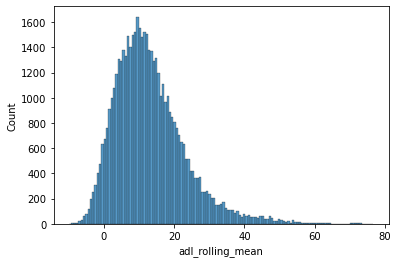

In [32]:
sns.histplot(y)

In [33]:
from scipy.stats import boxcox
from numpy import log

In [34]:
# splitting

from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,train_size=0.7) #full scaled X
x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.7)  #using partially scaled X
# x_train, x_test, y_train, y_test = train_test_split(X_scaled,y_,train_size=0.7) #full scaled X, boxcox y

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [36]:
# rf

model = RandomForestRegressor(n_estimators = 100,
                               max_depth = 10,
                               oob_score = True,
                               random_state = 123,
                               n_jobs = -1
                        )
model.fit(x_train,y_train)

train_score = cross_val_score(model,x_train,y_train,cv=5)
print(round(train_score.mean(),2)*100)

-0.0


In [37]:
y_pred = model.predict(x_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
print(metrics.r2_score(y_test,y_pred))

RMSE: 10.091637
0.00016760209110311397


In [38]:
from sklearn.metrics import mean_squared_error

testing_error = mean_squared_error(y_test,y_pred)
print(testing_error)

exp_var = metrics.explained_variance_score(y_test,y_pred)
print(exp_var)

101.84114329267837
0.00022257764637401145


In [39]:
cv_results = cross_validate(model,X,y,cv=10,scoring='r2',n_jobs=-1)

print(cv_results['test_score'])

[-0.00615151  0.00598625  0.00163733  0.00189457 -0.00103378  0.00537558
  0.01053327 -0.00203571 -0.00433325  0.00607321]


In [40]:
import pickle
with open('random_forest.pickle','wb') as f:
    pickle.dump(model,f)

In [41]:
test_data = pd.read_csv(file_path+'final_test_cleaned.csv')
test_data = test_data.drop(columns='index')

In [44]:
test_data = test_data.dropna()

In [46]:
set(X.columns)-set(test_data.columns)

set()

In [45]:
test_pred = model.predict(test_data)

ValueError: Number of features of the model must match the input. Model n_features is 35 and input n_features is 36 

In [ ]:
"""
ways to improve model 

-more weather data
    -wind speed, 
-use all data - try iterative training using pickles (xgb)
    -xgb_model (file name of stored xgb model or 'Booster' instance) – 
     Xgb model to be loaded before training (allows training continuation).
-using time series tehcnique -> should be removing seasonality + trend
    -make sure data is stationary
    
-efficiency 
    -pipelines
    -auto cleaner
"""

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
# # grid search

# random_grid = {
#     'bootstrap': [True, False],
#     'oob_score': [True]
#     'max_depth': [25, 50, 75, 100, None],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [100,500,1000]
# }

# rf = RandomForestRegressor(random_state=123)

# rf_random = RandomizedSearchCV(
#     estimator = rf, 
#     param_distributions = random_grid, 
#     n_iter = 100, 
#     cv = 5, 
#     verbose=1, 
#     random_state=123, 
#     n_jobs = -1)

# rf_random.fit(x_train, y_train)

In [ ]:
# rf_random.best_params_

In [ ]:
# param_grid = {
    
# }

# rf_grid = GridSearchCV(
#     estimator = rf, 
#     param_grid = param_grid, 
#     cv = 5, 
#     verbose = 1,
#     n_jobs = -1, 
# )

# rf_grid.fit(x_train, y_train)

In [ ]:
# rf_grid.best_params_